<a href="https://colab.research.google.com/github/dnguyend/rayleigh_newton/blob/master/colab/EigenTensorSparse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\newcommand{\hcT}{\hat{\mathcal{T}}}$

# Testing with sparse tensors as a multilinear function on a higher dimensional vector space.

This workbook computes shows examples for higher dimension tensors. We tests for $n=20, 50, 100$ and $m=3, 4, 5$. We hit memory constraints quickly if we use an array. Thus, we implement the tensor as a multilinear function, and its  gradient and hessian are implemented as vector and matrix functions. We added a new class *SparseTensor* that provide the RQI for such tensors.

As a test, we implement a derived class *ThreeFactorSparseTensor* of *SparseTensor* implementing a function of the form
$$\hcT = \sum_{i=1}^n t_{i0}x_i^m + \sum_{i=1}^{n-2}t_{i1}x_i^{m-2}x_{i+1}x_{i+2}
$$
The coefficients are stored in a matrix $t\_mat$ of size $n\times 2$. For $t_{i1}$, only coefficients up to $i=n-2$ are used.

In [1]:
!git clone https://github.com/dnguyend/rayleigh_newton

Cloning into 'rayleigh_newton'...
remote: Enumerating objects: 343, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 343 (delta 182), reused 272 (delta 139), pack-reused 0
Receiving objects: 100% (343/343), 14.93 MiB | 29.98 MiB/s, done.
Resolving deltas: 100% (182/182), done.


## Importing the main libraries.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rayleigh_newton.core.sparse_tensor import ThreeFactorSparseTensor


 ## Run a few sanity tests.
 We test evaluation, multilinearity, gradient and hessian, and test the Euler's Identity

In [3]:
def test_tns(m, n):
    # test for m >= 3
    np.random.seed(0)
    t_mat = np.random.randn(n, 2)
    t_mat[-m:, 1] = 0.
    tns = ThreeFactorSparseTensor(t_mat, m)

    x = np.random.randn(n)
    eta = np.random.randn(n)
    print("SANITY TEST evaluation")
    print(np.sum(tns.t_mat[:, 0]*x**m) + np.sum(tns.t_mat[:-2, 1]*x[:-2]**(m-2)*x[1:-1]*x[2:]))
    print(tns.eval(x)[0])

    print("SANITY TEST multi linear")
    print(tns.eval(3*x)[0], tns.eval(x)[0]*3**m)
    dlt = 1e-5

    print("SANITY TEST compare with numerical derivative")
    print((tns.eval(x+dlt*eta)[0] - tns.eval(x)[0])/dlt)
    print(np.sum(tns.eval(x)[1]*eta))

    print("SANITY TEST compare with numerical hessian")
    print((tns.eval(x+dlt*eta)[1] - tns.eval(x)[1])/dlt)
    print(tns.hess_eval(x)@eta)

    print("SANITY TEST compare the Euler Identity")
    print(m*tns.eval(x)[0]- np.sum(tns.eval(x)[1]*x))
    print(tns.hess_eval(x)@x - (m-1)*tns.eval(x)[1])

test_tns(3, 10)

SANITY TEST evaluation
-24.051665145595436
-24.051665145595436
SANITY TEST multi linear
-649.3949589310768 -649.3949589310768
SANITY TEST compare with numerical derivative
-6.821625530051278
-6.821544273660279
SANITY TEST compare with numerical hessian
[-4.28832476  0.05158085 -8.3339036   9.9454222   0.36828283  1.33005392
 -1.74201421 -2.96379247 -5.34340504 -0.83437065]
[-4.28832469  0.0515378  -8.33392448  9.94532083  0.36829913  1.3300351
 -1.74205072 -2.96381394 -5.34341356 -0.8343715 ]
SANITY TEST compare the Euler Identity
0.0
[ 1.42108547e-14  0.00000000e+00  1.77635684e-15  4.44089210e-16
 -8.88178420e-16 -4.44089210e-16  0.00000000e+00  0.00000000e+00
 -3.55271368e-15 -8.88178420e-16]


# Generate graphs

Now run one tensors per each pair (m, n)

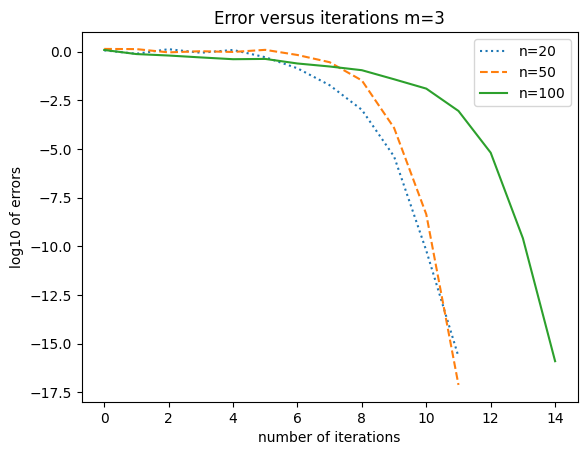

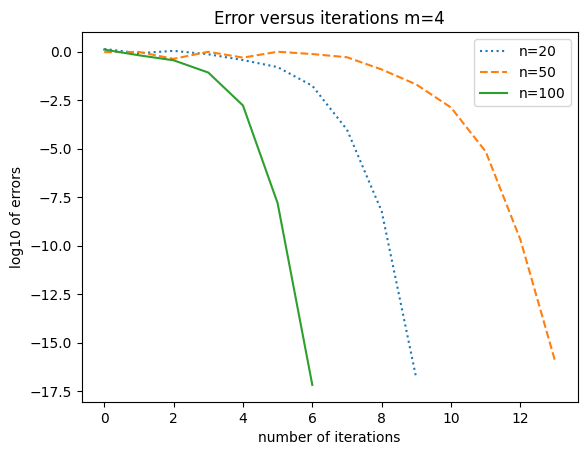

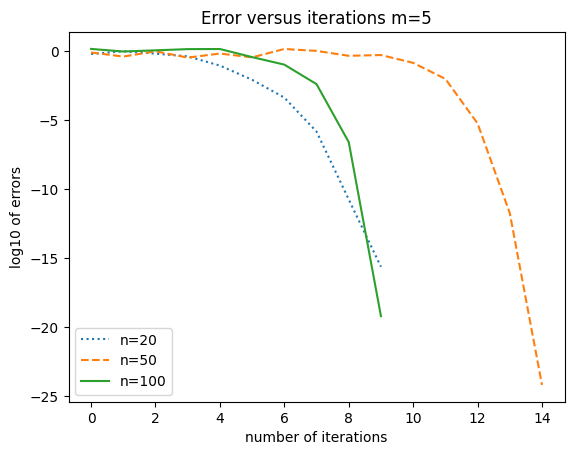

3 20 12 2.18e-16
3 50 12 7.72e-18
3 100 15 1.27e-16
4 20 10 1.40e-17
4 50 14 1.11e-16
4 100 7 6.63e-18
5 20 10 2.41e-16
5 50 15 6.82e-25
5 100 10 6.50e-20


In [18]:
def test_iter(m, n):
    # test for m >= 3
    np.random.seed(0)
    t_mat = np.random.randn(n, 2)
    t_mat[-m:, 1] = 0.
    tns = ThreeFactorSparseTensor(t_mat, m)

    return tns.schur_form_rayleigh(
        max_itr=200, delta=1e-13, x_init=None, save_err=True), t_mat


def run_all_iters():
    ret = {}
    linestyles = {20: 'dotted', 50: "dashed", 100: "solid"}
    for m in [3, 4, 5]:
        ret[m] = {}
        for n in  [20, 50, 100]:
            ret[m][n] = test_iter(m, n)
            plt.plot(np.log10(ret[m][n][0][-1][:, 1]), label="n=%d" % n, linestyle=linestyles[n])
            plt.legend()

            plt.xlabel("number of iterations")
            plt.ylabel("log10 of errors")
        plt.title("Error versus iterations m=%d" % m)
        plt.savefig("schur_%d.png" % (m))
        plt.show()

    for m in [3, 4, 5]:
        for n in  [20, 50, 100]:
            print(m, n, ret[m][n][0][-1].shape[0], "%.2e" % ret[m][n][0][-1][-1, 1])
    return ret

ret = run_all_iters()

# Last sanity check

For m = 3, n =100, the parameters for the multilinear function is in ret[3][100][1], the eigenvalue is in ret[3][100][0][1] and the eigenvector is in ret[3][100][0][0]. We compute 1/m * the gradient and compare below


In [5]:
print(np.linalg.norm(ret[3][100][0][0]))
t_mat_test = ret[3][100][1]
tns_test = ThreeFactorSparseTensor(t_mat_test, 3)

print(np.max(np.abs(1/3*tns_test.eval(ret[3][100][0][0])[1] - ret[3][100][0][1]*ret[3][100][0][0])))


1.0
5.551115123125783e-17


In [13]:
ret[3][100][0][-1][-1, 1]

1.2749055897875684e-16